In [14]:
# Read in goal_shot_rows.csv

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

import data_prep

pd.options.mode.chained_assignment = None  # default='warn'

model_path = '0502_xG_Model_1500K.pt'

In [17]:
def create_input_data_from_csv(path_to_csv):
    df = pd.read_csv(path_to_csv)

    # get list of ilocs of rows where the 'Event' column is 'GOAL or SHOT or MISS'
    goal_shot_rows = df.loc[df['Event'].isin(['GOAL', 'SHOT', 'MISS'])]

    # shift the dataframe by 1 row
    shifted_df = df.shift(1)
    shifted_df.columns = ['prev_' + name for name in df.columns]

    # combine goal_shot_rows with shifted_df, but using rows from goal_shot_rows
    goal_shot_rows = pd.concat([goal_shot_rows, shifted_df.loc[goal_shot_rows.index]], axis=1)

    goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 0]
    goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 5]

    # Create "home_or_away" column based on if "Ev_team" is the same as "Home_Team" or "Away_Team"
    goal_shot_rows['home_or_away'] = goal_shot_rows.apply(lambda x: 'home' if x['Ev_Team'] == x['Home_Team'] else 'away', axis=1)
    
    # check to see if on power play if "home_or_away" is equal to "home" and "Strength" is equal to "5x4" or "home_or_away" is equal to "away" and "Strength" is equal to "4x5"
    goal_shot_rows['true_strength'] = goal_shot_rows.apply(lambda x: "5x4" if (x['home_or_away'] == 'home' and x['Strength'] == '5x4' ) or (x['home_or_away'] == 'away' and x['Strength'] == '4x5') else "5x5", axis=1)

    # similar as above, but for 5x3
    goal_shot_rows['true_strength'] = goal_shot_rows.apply(lambda x: "5x3" if (x['home_or_away'] == 'home' and x['Strength'] == '5x3' ) or (x['home_or_away'] == 'away' and x['Strength'] == '3x5') else x['true_strength'], axis=1)

    # similar as above, but for 6x5
    goal_shot_rows['true_strength'] = goal_shot_rows.apply(lambda x: "6x5" if (x['home_or_away'] == 'home' and x['Strength'] == '6x5' ) or (x['home_or_away'] == 'away' and x['Strength'] == '5x6') else x['true_strength'], axis=1)

    # similar as above, but for 4x3
    goal_shot_rows['true_strength'] = goal_shot_rows.apply(lambda x: "4x3" if (x['home_or_away'] == 'home' and x['Strength'] == '4x3' ) or (x['home_or_away'] == 'away' and x['Strength'] == '3x4') else x['true_strength'], axis=1)

    # similar as above,but for 3x3
    goal_shot_rows['true_strength'] = goal_shot_rows.apply(lambda x: "3x3" if (x['home_or_away'] == 'home' and x['Strength'] == '3x3' ) or (x['home_or_away'] == 'away' and x['Strength'] == '3x3') else x['true_strength'], axis=1)

    # check to see if a shot is on an empty net by checking if home_or_away is equal to "home" and "Away_Goalie" is equal to "None" or home_or_away is equal to "away" and "Home_Goalie" is equal to "None"
    goal_shot_rows['on_empty_net'] = goal_shot_rows.apply(lambda x: 1 if (x['home_or_away'] == 'home' and x['Away_Goalie'] == '') or (x['home_or_away'] == 'away' and x['Home_Goalie'] == '') else 0, axis=1)


    val_input_data = goal_shot_rows[['Event', 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC', 'home_or_away', 'true_strength', 'on_empty_net', 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC']]
    val_result_data = goal_shot_rows['Event']
    val_result_data = val_result_data.apply(lambda x: 1 if x == "GOAL" else 0)

    # Create a new column "is_PS" if prev_Type starts with "PS"
    val_input_data['prev_Type'] = val_input_data['prev_Type'].fillna("")
    val_input_data['is_PS'] = val_input_data['prev_Type'].str.startswith('PS').astype(int)

    # For "prev_Type" column, if "min)" or "maj)", then convert it to just "PENL"
    val_input_data['prev_Type'] = val_input_data['prev_Type'].apply(lambda x: 'PENL' if x.endswith('min)') else x)
    
    # For "prev_Event" column, if it start with "PS", then convert it to just "PS"
    # val_input_data['prev_Event'] = val_input_data['prev_Event'].apply(lambda x: 'PS' if x.startswith('PS') else x)
    print(val_input_data['prev_Type'].unique())

    val_input_data = val_input_data.drop(columns=['Event'])

    # Split out the data between numeric values (can carry forward) and categorical values (need to be turned into binary columns)
    val_input_data_numeric = val_input_data[['Seconds_Elapsed', 'xC', 'yC', 'on_empty_net','prev_Seconds_Elapsed', 'prev_xC', 'prev_yC', 'is_PS']]
    val_input_data_categorical = pd.DataFrame()



    for column in ['Period', 'Type', 'true_strength', 'home_or_away']:
        dummy_columns = pd.get_dummies(val_input_data[column])
        val_input_data_categorical = pd.concat([dummy_columns, val_input_data_categorical], axis=1)

    for column in ['prev_Event', 'prev_Strength', 'prev_Type']:
        dummy_columns = pd.get_dummies(val_input_data[column])

        # rename all columns with a prefix of "prev_"
        dummy_columns.columns = ['prev_' + str(col) for col in dummy_columns.columns]
        val_input_data_categorical = pd.concat([val_input_data_categorical, dummy_columns], axis=1)
        
    # change all True/False to 1/0
    val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)

    # combine the two dataframes
    val_input_data_combined = pd.concat([val_input_data_numeric, val_input_data_categorical], axis=1)

    #set val_input_data2 to be all floats
    val_input_data_combined = val_input_data_combined.astype(float)

    print(val_input_data_combined.columns)

    columns = ['Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                        '6x5',             'BACKHAND',            'DEFLECTED',
                  'SLAP SHOT',            'SNAP SHOT',               'TIP-IN',
                'WRAP-AROUND',           'WRIST SHOT',                      1,
                            2,                      3,                      4,
                 'prev_BLOCK',             'prev_CHL',             'prev_FAC',
                  'prev_GEND',            'prev_GIVE',            'prev_GOAL',
                   'prev_HIT',            'prev_MISS',            'prev_PENL',
                  'prev_SHOT',            'prev_STOP',            'prev_TAKE',
                  'prev_-1x3',            'prev_-1x5',             'prev_0x1',
                   'prev_0x5',             'prev_3x3',             'prev_3x4',
                   'prev_3x5',             'prev_4x3',             'prev_4x4',
                   'prev_4x5',             'prev_5x0',             'prev_5x3',
                   'prev_5x4',             'prev_5x5',             'prev_5x6',
                   'prev_6x5',                'prev_',        'prev_BACKHAND',
             'prev_DEFLECTED',       'prev_SLAP SHOT',       'prev_WRIST SHOT',
             'prev_SNAP SHOT',          'prev_TIP-IN',     'prev_WRAP-AROUND',
            ]

    # For each column in input_data_combined, check if it exists in val_input_data_combined, if not add it as all 0s
    for column in columns:
        if column not in val_input_data_combined.columns:
                val_input_data_combined[column] = 0

    for column in val_input_data_combined.columns:
        if column not in columns:
                if column in val_input_data_combined.columns:
                    print(f"Column {column} not in columns")
                    val_input_data_combined = val_input_data_combined.drop(column, axis=1)


    # reduce val_input_data_combined to have the same columns as input_data_combined
    val_input_data_combined = val_input_data_combined[columns]

    # change all NaN numbers to 0
    val_input_data_combined = val_input_data_combined.fillna(0)

    model = nn.Sequential(
        nn.Linear(64, 240),
        nn.ReLU(),
        nn.Linear(240, 100),
        nn.ReLU(),
        nn.Linear(100, 1),
        nn.Sigmoid()
    )

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.cpu()

    x = torch.tensor(val_input_data_combined.values, dtype=torch.float32)
    y = torch.tensor(val_result_data.values, dtype=torch.float32)
    result = model(x)

    # add the probability of a goal to val_input_data_combined
    goal_shot_rows['Goal_Probability'] = result.detach().numpy()

    return val_input_data_combined, val_result_data, goal_shot_rows

# Game Evaluation

For game prediction, I'm stealing a bit from MoneyPuck, the inputs are:

1. Home team xG ratrio full for season w/linear delay
2. same, but for away team
3. home team days of rest
4. away team days of rest
5. num of games by the home team
6. num of games by the away team


Eventually, need to add some amount of goalie calculation/generic player strength calculation, but that will have to wait.

Note to self: need this for f-score: https://stackoverflow.com/questions/67959327/how-to-calculate-the-f1-score


In [18]:
def get_single_game_xG_totals(original_input, game_id, state = "any"):
    game_rows = original_input[original_input["Game_Id"] == game_id]

    if state != "any":
        game_rows = game_rows[game_rows["Strength"] == state]

    # get first value of Home_Team and Away_Team
    home_team = game_rows["Home_Team"].iloc[0]
    away_team = game_rows["Away_Team"].iloc[0]

    # get all rows where the Ev_Team is the home team
    home_team_rows = game_rows[game_rows["Ev_Team"] == home_team]

    # get all rows where the Ev_Team is the away team
    away_team_rows = game_rows[game_rows["Ev_Team"] == away_team]

    # add a new column "total_xG" to home_team_rows and away_team_rows
    home_team_rows["total_xG"] = home_team_rows["Goal_Probability"].cumsum()
    away_team_rows["total_xG"] = away_team_rows["Goal_Probability"].cumsum()

    # time elapsed is (period - 1) * 1200 + seconds_elapsed
    home_team_rows["Seconds_Elapsed"] = (home_team_rows["Period"] - 1) * 1200 + home_team_rows["Seconds_Elapsed"]
    home_team_rows["Minutes_Elapsed"] = home_team_rows["Seconds_Elapsed"] / 60

    # print home_team_rows to csv
    # home_team_rows.to_csv("home_team_rows.csv")

    # time elapsed is (period - 1) * 1200 + seconds_elapsed
    away_team_rows["Seconds_Elapsed"] = (away_team_rows["Period"] - 1) * 1200 + away_team_rows["Seconds_Elapsed"]
    away_team_rows["Minutes_Elapsed"] = away_team_rows["Seconds_Elapsed"] / 60

    # away_team_rows.to_csv("away_team_rows.csv")

    total_home_xG = home_team_rows["total_xG"].iloc[-1].round(2)
    total_away_xG = away_team_rows["total_xG"].iloc[-1].round(2)

    # combine home_team_rows and away_team_rows into one dataframe
    combined_rows = pd.concat([home_team_rows, away_team_rows])

    home_score = home_team_rows["Home_Score"].iloc[-1]
    away_score = away_team_rows["Away_Score"].iloc[-1]

    return combined_rows, home_team, total_home_xG, away_team, total_away_xG, home_score, away_score


In [19]:

# This has to be done season by season, or the game_ids will merge together in a broken way
def get_season_xG_weights(original_input, season_id):
    # split original_input into multiple dataframes based off of game_id
    game_ids = original_input["Game_Id"].unique()
    # remove all instances of game_ids that start with 3
    game_ids = [x for x in game_ids if str(x)[0] != "3"]

    nhl_teams = {}
    nhl_teams_predicted_xG = {}

    results = []
    predictions = []
    predictions_rounded = []

    training_input = []

    # read in the schedule csv into a dictionary, using game_id as the key
    schedule = pd.read_csv("schedule/schedule.csv")
    schedule = schedule.set_index("game_id")

    for game_id in game_ids:
        # print(f"Game ID: {game_id}")
        combined_rows, home_team, total_home_xG, away_team, total_away_xG, home_score, away_score = get_single_game_xG_totals(original_input, game_id, "any")

        # add the total_xG of the home team and away team to nhl_teams
        if home_team not in nhl_teams:
            nhl_teams[home_team] = {"xG_percent": [], "total_games": 0, "game_dates" : []}
        if away_team not in nhl_teams:
            nhl_teams[away_team] = {"xG_percent": [], "total_games": 0, "game_dates" : []}

        # if both teams have more than 20 games played, create a prediciton for the game
        if nhl_teams[home_team]["total_games"] >= 20 and nhl_teams[away_team]["total_games"] >= 20:
            # get the average of last 20 games for home_team and away_team
            # home_xG_percent_avg = np.mean(nhl_teams[home_team]["xG_percent"])
            # away_xG_percent_avg = np.mean(nhl_teams[away_team]["xG_percent"])

            # home_xG_percent_avg = home_xG_percent_avg / (home_xG_percent_avg + away_xG_percent_avg)
            # away_xG_percent_avg = away_xG_percent_avg / (home_xG_percent_avg + away_xG_percent_avg)

            # # Apply linear decay to each home_team's xg_percent game by game
            decay_rate = 0.01  # Adjust the decay rate as desired


            # I think this logic still has some flaws, but we'll get to it later

            # Calculate the decayed xg_percent for each game
            if (len(nhl_teams[home_team]["xG_percent"]) >= len(nhl_teams[away_team]["xG_percent"])):
                num_games = len(nhl_teams[away_team]["xG_percent"])
                home_decayed_xg_percent = np.zeros_like(nhl_teams[away_team]["xG_percent"])
                away_decayed_xg_percent = np.zeros_like(nhl_teams[away_team]["xG_percent"])
            else:
                num_games = len(nhl_teams[home_team]["xG_percent"])
                home_decayed_xg_percent = np.zeros_like(nhl_teams[home_team]["xG_percent"])
                away_decayed_xg_percent = np.zeros_like(nhl_teams[home_team]["xG_percent"])


            len_home_games = len(nhl_teams[home_team]["xG_percent"])
            for i in range(num_games):
                home_decayed_xg_percent[i] = nhl_teams[home_team]["xG_percent"][(len_home_games - i -1 )] * (1 - (decay_rate * i))

            len_away_games = len(nhl_teams[away_team]["xG_percent"])
            for i in range(num_games):
                away_decayed_xg_percent[i] = nhl_teams[away_team]["xG_percent"][(len_away_games - i - 1)] * (1 - (decay_rate * i))

            home_xG_percent_sum = np.sum(home_decayed_xg_percent)
            away_xG_percent_sum = np.sum(away_decayed_xg_percent)
            
            home_xG_percent_avg = home_xG_percent_sum / (home_xG_percent_sum + away_xG_percent_sum)
            away_xG_percent_avg = away_xG_percent_sum / (home_xG_percent_sum + away_xG_percent_sum)

           

            # Calculate the days of rest for each team (format is YYYY-MM-DD):
            home_team_prev_date = nhl_teams[home_team]["game_dates"][-1]
            away_team_prev_date = nhl_teams[away_team]["game_dates"][-1]


            # Todo: add a way to get the season id programatically off of the game's date
            alt_game_id = season_id + "0" + str(game_id)
            # print(alt_game_id)

            schedule_row = schedule.loc[int(alt_game_id)]
            home_team_score = schedule_row["home_score"]
            away_team_score = schedule_row["away_score"]

            # Calculate the days of rest for each team
            # calucluate the difference in days between two strings with format YYYY-MM-DD
            # Convert strings to datetime objects
            home_prev_date = datetime.strptime(home_team_prev_date, "%Y-%m-%d")
            away_prev_date = datetime.strptime(away_team_prev_date, "%Y-%m-%d")
            current_date = datetime.strptime(combined_rows["Date"].iloc[0], "%Y-%m-%d")

            home_team_days_of_rest = (current_date - home_prev_date).days - 1
            away_team_days_of_rest = (current_date - away_prev_date).days - 1

            if (home_team_days_of_rest > 3):
                home_team_days_of_rest = 3
            if (away_team_days_of_rest > 3):
                away_team_days_of_rest = 3

            if home_team not in nhl_teams_predicted_xG:
                nhl_teams_predicted_xG[home_team] = {}
            if away_team not in nhl_teams_predicted_xG:
                nhl_teams_predicted_xG[away_team] = {}
            nhl_teams_predicted_xG[home_team][game_id] = {"xg_sum": home_xG_percent_sum, "days_rest": home_team_days_of_rest, "num_games": nhl_teams[home_team]["total_games"]}
            nhl_teams_predicted_xG[away_team][game_id] = {"xg_sum": away_xG_percent_sum, "days_rest": away_team_days_of_rest, "num_games": nhl_teams[away_team]["total_games"]}
            training_input.append({"home_xg_percent_avg": home_xG_percent_avg,
                                    "home_days_rest": home_team_days_of_rest, "away_days_rest": away_team_days_of_rest,
                                    "home_num_games": nhl_teams[home_team]["total_games"],
                                    "away_num_games": nhl_teams[away_team]["total_games"],
                                    "game_result": home_team_score > away_team_score})
            

            results.append(home_team_score > away_team_score)
            predictions.append(home_xG_percent_avg)
            predictions_rounded.append(home_xG_percent_avg.round())

        home_xG_percent = total_home_xG / (total_home_xG + total_away_xG)
        away_xG_percent = total_away_xG / (total_home_xG + total_away_xG)

        nhl_teams[home_team]["xG_percent"].append(home_xG_percent)
        nhl_teams[away_team]["xG_percent"].append(away_xG_percent)
        nhl_teams[home_team]["total_games"] += 1
        nhl_teams[away_team]["total_games"] += 1
        nhl_teams[home_team]["game_dates"].append(combined_rows["Date"].iloc[0])
        nhl_teams[away_team]["game_dates"].append(combined_rows["Date"].iloc[0])

    # get the accuracy of the model
    results_tensor = torch.tensor(results, dtype=torch.float32)
    predictions_tensor = torch.tensor(predictions, dtype=torch.float32)
    predictions_rounded_tensor = torch.tensor(predictions_rounded, dtype=torch.float32)

    accuracy = (predictions_rounded_tensor == results_tensor).float().mean()

    # calculate log loss of predicitons
    log_loss = nn.BCELoss()
    log_loss_results = log_loss(predictions_tensor, results_tensor)

    # print(f"Accuracy {accuracy}")
    # print(f"log loss {log_loss_results}")

    return nhl_teams, nhl_teams_predicted_xG, training_input

# Creating input data for the game prediciton neural network

We need:

1. To get result data (preferably through the schedule, but working on it)
2. To get the input data:
    1. Home team xG percentage sum for season w/linear delay
    2. same, but for away team
    3. home team days of rest
    4. away team days of rest
    5. num of games by the home team
    6. num of games by the away team

In [54]:
# read in nhl_pbp_20232024.csv
val_input_data1, val_result_data1, original_input1 = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_20182019.csv")

nhl_teams1, nhl_teams_predicted_xG1, training_input1 = get_season_xG_weights(original_input1, "2018")

['' 'BACKHAND' 'SNAP SHOT' 'TIP-IN' 'WRIST SHOT' 'SLAP SHOT' 'WRAP-AROUND'
 'DEFLECTED' 'PENL' 'Fighting (maj)']


C:\Users\JoshG\AppData\Local\Temp\ipykernel_23040\749814959.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                        '6x5',             'BACKHAND',            'DEFLECTED',
                  'SLAP SHOT',            'SNAP SHOT',               'TIP-IN',
                'WRAP-AROUND',           'WRIST SHOT',                      1,
                            2,                      3,                      4,
                 'prev_BLOCK',             'prev_CHL',             'prev_FAC',
                  'prev_GEND',            'prev_GIVE',            'prev_GOAL',
                   'prev_HIT',            'prev_MISS',            'prev_PENL',
                  'prev_SHOT',            'prev_STOP

In [56]:
# read in nhl_pbp_20232024.csv
val_input_data2, val_result_data2, original_input2 = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_20202021.csv")

nhl_teams2, nhl_teams_predicted_xG2, training_input2 = get_season_xG_weights(original_input2, "2020")

val_input_data2, val_result_data3, original_input3 = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_20222023.csv")

nhl_teams3, nhl_teams_predicted_xG3, training_input3 = get_season_xG_weights(original_input3, "2022")

# combine the two training_inputs
training_input = training_input1 + training_input2 + training_input3

['' 'SNAP SHOT' 'SLAP SHOT' 'WRIST SHOT' 'BACKHAND' 'TIP-IN' 'WRAP-AROUND'
 'DEFLECTED' 'PENL']


C:\Users\JoshG\AppData\Local\Temp\ipykernel_23040\749814959.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                        '6x5',             'BACKHAND',            'DEFLECTED',
                  'SLAP SHOT',            'SNAP SHOT',               'TIP-IN',
                'WRAP-AROUND',           'WRIST SHOT',                      1,
                            2,                      3,                      4,
                            6,           'prev_BLOCK',             'prev_CHL',
                'prev_DELPEN',             'prev_FAC',            'prev_GEND',
                  'prev_GIVE',             'prev_HIT',            'prev_MISS',
                  'prev_PEND',            'prev_PENL

C:\Users\JoshG\AppData\Local\Temp\ipykernel_23040\749814959.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                        '6x5',             'BACKHAND',            'DEFLECTED',
                  'SLAP SHOT',            'SNAP SHOT',               'TIP-IN',
                'WRAP-AROUND',           'WRIST SHOT',                      1,
                            2,                      3,                      4,
                            6,                      7,           'prev_BLOCK',
                   'prev_CHL',          'prev_DELPEN',             'prev_FAC',
                  'prev_GIVE',             'prev_HIT',            'prev_MISS',
                  'prev_PENL',            'prev_SHOT

In [57]:
# Convert training_input to a dataframe
training_input_df = pd.DataFrame(training_input)

print(training_input_df.columns)

game_result_data_df = training_input_df["game_result"]

training_input_df = training_input_df.drop(columns=['game_result'])


Index(['home_xg_percent_avg', 'home_days_rest', 'away_days_rest',
       'home_num_games', 'away_num_games', 'game_result'],
      dtype='object')


In [58]:
print(training_input_df["home_days_rest"].value_counts())
print(training_input_df["away_days_rest"].value_counts())
print(training_input_df.shape)

home_days_rest
1    1577
2     406
0     316
3     182
Name: count, dtype: int64
away_days_rest
1    1430
0     554
2     359
3     138
Name: count, dtype: int64
(2481, 5)


In [59]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

x = torch.tensor(training_input_df.values, dtype=torch.float32)
y = torch.tensor(game_result_data_df.values, dtype=torch.float32)

x.to(device)
y.to(device)

model = nn.Sequential(
    nn.Linear(5, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)

model.to(device)


loss_fn = nn.BCELoss()  # binary cross entropy
loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Using device: cuda



In [60]:
n_epochs = 350000
batch_size = 256

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    for i in range(0, len(x), batch_size):
        Xbatch = x[i:i+batch_size]
        y_pred = model(Xbatch.cuda())
        ybatch = y[i:i+batch_size]
        #loss = loss_fn(y_pred, ybatch)
        loss = loss_fn(y_pred.squeeze(), ybatch.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 1000 == 0:
        print(f'{epoch}, {loss}')


# compute accuracy (no_grad is optional)
# y_pred = model(x.cuda()).cuda()
 

torch.save(model.state_dict(), '0502_Game_prediciton_percent_model_350k.pt')

0, 6.417440414428711
1000, 0.6838448643684387
2000, 0.6693261861801147
3000, 0.6512095332145691
4000, 0.633985161781311
5000, 0.6214830279350281
6000, 0.6135943531990051
7000, 0.6089943051338196
8000, 0.6064806580543518
9000, 0.6051081418991089
10000, 0.6043392419815063
11000, 0.6038800477981567
12000, 0.6036486625671387
13000, 0.6035001277923584
14000, 0.6034111380577087
15000, 0.6033082604408264
16000, 0.6032078266143799
17000, 0.6031580567359924
18000, 0.6028863787651062
19000, 0.6027942895889282
20000, 0.6027340888977051
21000, 0.6026672720909119
22000, 0.60262531042099
23000, 0.6025961637496948
24000, 0.6025782227516174
25000, 0.602553129196167
26000, 0.6025782823562622
27000, 0.6025524139404297
28000, 0.6025174856185913
29000, 0.60250324010849
30000, 0.6024724841117859
31000, 0.6024298071861267
32000, 0.6023854613304138
33000, 0.6023001670837402
34000, 0.6022762060165405
35000, 0.6022256016731262
36000, 0.6021682620048523
37000, 0.6020920276641846
38000, 0.6019443273544312
39000,

In [218]:
torch.save(model.state_dict(), '0430_Game_prediciton_percent_model_50k.pt')

Accuracy 0.5957275292220878
[1. 1. 1. ... 0. 0. 0.]


(array([  1.,   1.,   3.,  22.,  30.,  62.,  79., 140., 211., 236., 274.,
        312., 281., 240., 204., 168., 111.,  62.,  34.,  10.]),
 array([0.1122242 , 0.14836074, 0.1844973 , 0.22063385, 0.2567704 ,
        0.29290694, 0.32904351, 0.36518005, 0.40131661, 0.43745315,
        0.47358972, 0.50972629, 0.54586279, 0.58199936, 0.61813593,
        0.65427244, 0.690409  , 0.72654557, 0.76268214, 0.79881865,
        0.83495522]),
 <BarContainer object of 20 artists>)

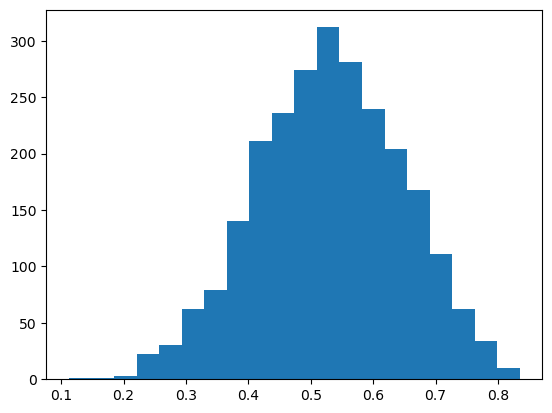

In [30]:
model = nn.Sequential(
    nn.Linear(5, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)


model.load_state_dict(torch.load('0502_Game_prediciton_percent_model_50k.pt'))
model.eval()
model.cpu()

x = torch.tensor(training_input_df.values, dtype=torch.float32)
y = torch.tensor(game_result_data_df.values, dtype=torch.float32)

y_pred = model(x)



# convert the tensor to a numpy array
y_pred = y_pred.detach().numpy()
y = y.detach().numpy()


# accuracy = (y_pred.round() == y).float().mean()\
accuracy_results = []

for i in range(len(y_pred)):
    # print(f"Prediction: {y_pred[i][0]} Actual: {y[i]}")
    if y_pred[i][0].round() == y[i]:
        accuracy_results.append(1)
    else:
        accuracy_results.append(0)

accuracy = sum(accuracy_results) / len(accuracy_results)
print(f"Accuracy {accuracy}")
# print(f"log loss {log_loss_results}")
# calculate log loss of predicitons

print(y)
# make a histogram of y_pred
plt.hist(y_pred, bins=20)




In [ ]:
val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_20182019.csv")

nhl_teams, nhl_teams_predicted_xG, training_input = get_season_xG_weights(original_input, "2018")

# Convert training_input to a dataframe
training_input_df = pd.DataFrame(training_input)
game_result_data_df = training_input_df["game_result"]
training_input_df = training_input_df.drop(columns=['game_result'])

C:\Users\JoshG\AppData\Local\Temp\ipykernel_48820\2609486208.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


(117757, 78)


Accuracy 0.6070133010882709
log loss 0.6596757769584656


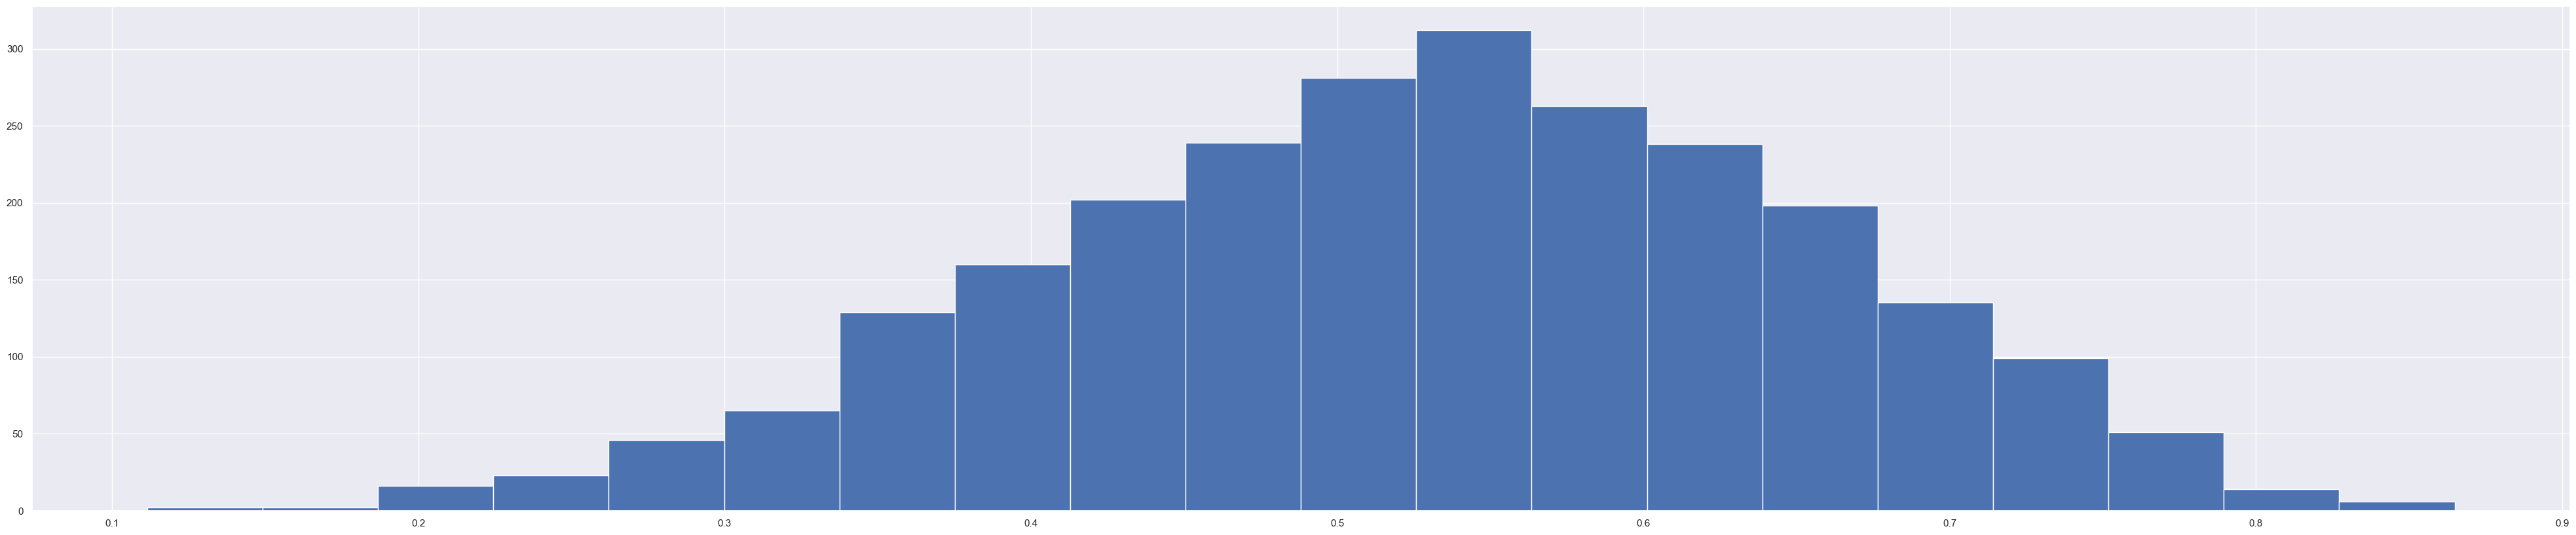

In [46]:

model.load_state_dict(torch.load('0502_Game_prediciton_percent_model_2M.pt'))
model.eval()
model.cpu()

x = torch.tensor(training_input_df.values, dtype=torch.float32)
y = torch.tensor(game_result_data_df.values, dtype=torch.float32)

y_pred = model(x)


# convert the tensor to a numpy array
y_pred = y_pred.detach().numpy()
y = y.detach().numpy()


# accuracy = (y_pred.round() == y).float().mean()\
accuracy_results = []

for i in range(len(y_pred)):
    # print(f"Prediction: {y_pred[i][0]} Actual: {y[i]}")
    if y_pred[i][0].round() == y[i]:
        accuracy_results.append(1)
    else:
        accuracy_results.append(0)

accuracy = sum(accuracy_results) / len(accuracy_results)
print(f"Accuracy {accuracy}")

plt.hist(y_pred, bins=20)

y_pred_flat = y_pred.flatten()
y_flat = y.flatten()

results_tensor = torch.tensor(y_pred_flat, dtype=torch.float32)
predictions_tensor = torch.tensor(y_pred_flat, dtype=torch.float32)
predictions_rounded = np.round(y_pred_flat)
predictions_rounded_tensor = torch.tensor(predictions_rounded, dtype=torch.float32)

accuracy = (predictions_rounded_tensor == results_tensor).float().mean()

# calculate log loss of predicitons
log_loss = nn.BCELoss()
log_loss_results = log_loss(predictions_tensor, results_tensor)

print(f"log loss {log_loss_results}")


In [47]:
from sklearn.metrics import f1_score

years = ["20172018", "20182019", "20192020", "20202021", "20212022", "20222023", "20232024"]
# years = ["20172018", "20192020", "20212022", "20232024"]

meta_training_predictions = []
meta_results = []
meta_predictions = []

for year in years:
    csv_path = f"C:\\Users\\JoshG\\hockey_scraper_data\\csvs\\nhl_pbp_{year}.csv"
    val_input_data, val_result_data, original_input = create_input_data_from_csv(csv_path)

    nhl_teams, nhl_teams_predicted_xG, training_input = get_season_xG_weights(original_input, year[0:4])

    # Convert training_input to a dataframe
    training_input_df = pd.DataFrame(training_input)
    game_result_data_df = training_input_df["game_result"]
    training_input_df = training_input_df.drop(columns=['game_result'])

    model.load_state_dict(torch.load('0502_Game_prediciton_percent_model_350k.pt'))
    model.eval()
    model.cpu()

    x = torch.tensor(training_input_df.values, dtype=torch.float32)
    y = torch.tensor(game_result_data_df.values, dtype=torch.float32)

    y_pred = model(x)

    # convert the tensor to a numpy array
    y_pred = y_pred.detach().numpy()
    y = y.detach().numpy()

    # append y to meta_results
    meta_results.append(y)
    # append y_pred to meta_predictions
    meta_predictions.append(y_pred)
    meta_training_predictions.append(training_input_df)


    # accuracy = (y_pred.round() == y).float().mean()\
    accuracy_results = []

    for i in range(len(y_pred)):
        # print(f"Prediction: {y_pred[i][0]} Actual: {y[i]}")
        if y_pred[i][0].round() == y[i]:
            accuracy_results.append(1)
        else:
            accuracy_results.append(0)

    accuracy = sum(accuracy_results) / len(accuracy_results)
    # print(f"Accuracy {accuracy}")


    # # convert the tensor to a numpy array
    # y_pred = y_pred.detach().numpy()
    # y = y.detach().numpy()

    # print(len(x))
    # print(len(y))
    # print(len(y_pred))


    # # accuracy = (y_pred.round() == y).float().mean()\
    # accuracy_results = []

    # for i in range(len(y_pred)):
    #     # print(f"Prediction: {y_pred[i][0]} Actual: {y[i]}")
    #     if y_pred[i][0].round() == y[i]:
    #         accuracy_results.append(1)
    #     else:
    #         accuracy_results.append(0)

    # accuracy = sum(accuracy_results) / len(accuracy_results)

    

    y_pred_flat = y_pred.flatten()
    y_flat = y.flatten()

    results_tensor = torch.tensor(y_pred_flat, dtype=torch.float32)
    predictions_tensor = torch.tensor(y_pred_flat, dtype=torch.float32)
    predictions_rounded = np.round(y_pred_flat)
    predictions_rounded_tensor = torch.tensor(predictions_rounded, dtype=torch.float32)

    # accuracy = (predictions_rounded_tensor == results_tensor).float().mean()

    # calculate log loss of predicitons
    log_loss = nn.BCELoss()
    log_loss_results = log_loss(predictions_tensor, results_tensor)
        
    print(f"year: {year} Accuracy {accuracy} loss {log_loss_results}")

    # plt.hist(y_pred, bins=20)

['WRIST SHOT' '' 'SLAP SHOT' 'SNAP SHOT' 'DEFLECTED' 'BACKHAND' 'TIP-IN'
 'PENL' 'WRAP-AROUND' 'Fighting (maj)']


C:\Users\JoshG\AppData\Local\Temp\ipykernel_23040\749814959.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                        '6x5',             'BACKHAND',            'DEFLECTED',
                  'SLAP SHOT',            'SNAP SHOT',               'TIP-IN',
                'WRAP-AROUND',           'WRIST SHOT',                      1,
                            2,                      3,                      4,
                 'prev_BLOCK',             'prev_CHL',             'prev_FAC',
                  'prev_GIVE',            'prev_GOAL',             'prev_HIT',
                  'prev_MISS',            'prev_PENL',            'prev_SHOT',
                  'prev_STOP',            'prev_TAKE

C:\Users\JoshG\AppData\Local\Temp\ipykernel_23040\749814959.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                        '6x5',             'BACKHAND',            'DEFLECTED',
                  'SLAP SHOT',            'SNAP SHOT',               'TIP-IN',
                'WRAP-AROUND',           'WRIST SHOT',                      1,
                            2,                      3,                      4,
                 'prev_BLOCK',             'prev_CHL',             'prev_FAC',
                  'prev_GEND',            'prev_GIVE',            'prev_GOAL',
                   'prev_HIT',            'prev_MISS',            'prev_PENL',
                  'prev_SHOT',            'prev_STOP

C:\Users\JoshG\AppData\Local\Temp\ipykernel_23040\749814959.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                        '6x5',             'BACKHAND',            'DEFLECTED',
                  'SLAP SHOT',            'SNAP SHOT',               'TIP-IN',
                'WRAP-AROUND',           'WRIST SHOT',                      1,
                            2,                      3,                      4,
                            6,                      7,                      8,
                 'prev_BLOCK',             'prev_CHL',          'prev_DELPEN',
                 'prev_EISTR',             'prev_FAC',            'prev_GEND',
                  'prev_GIVE',            'prev_GOAL

C:\Users\JoshG\AppData\Local\Temp\ipykernel_23040\749814959.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                        '6x5',             'BACKHAND',            'DEFLECTED',
                  'SLAP SHOT',            'SNAP SHOT',               'TIP-IN',
                'WRAP-AROUND',           'WRIST SHOT',                      1,
                            2,                      3,                      4,
                            6,           'prev_BLOCK',             'prev_CHL',
                'prev_DELPEN',             'prev_FAC',            'prev_GEND',
                  'prev_GIVE',             'prev_HIT',            'prev_MISS',
                  'prev_PEND',            'prev_PENL

C:\Users\JoshG\AppData\Local\Temp\ipykernel_23040\749814959.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                        '6x5',             'BACKHAND',            'DEFLECTED',
                  'SLAP SHOT',            'SNAP SHOT',               'TIP-IN',
                'WRAP-AROUND',           'WRIST SHOT',                      1,
                            2,                      3,                      4,
                            6,           'prev_BLOCK',             'prev_CHL',
                'prev_DELPEN',             'prev_FAC',            'prev_GIVE',
                   'prev_HIT',            'prev_MISS',            'prev_PENL',
                  'prev_SHOT',            'prev_STOP

C:\Users\JoshG\AppData\Local\Temp\ipykernel_23040\749814959.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                        '6x5',             'BACKHAND',            'DEFLECTED',
                  'SLAP SHOT',            'SNAP SHOT',               'TIP-IN',
                'WRAP-AROUND',           'WRIST SHOT',                      1,
                            2,                      3,                      4,
                            6,                      7,           'prev_BLOCK',
                   'prev_CHL',          'prev_DELPEN',             'prev_FAC',
                  'prev_GIVE',             'prev_HIT',            'prev_MISS',
                  'prev_PENL',            'prev_SHOT

C:\Users\JoshG\AppData\Local\Temp\ipykernel_23040\749814959.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                   'BACKHAND',            'DEFLECTED',            'SLAP SHOT',
                  'SNAP SHOT',               'TIP-IN',          'WRAP-AROUND',
                 'WRIST SHOT',                      1,                      2,
                            3,                      4,           'prev_BLOCK',
                   'prev_CHL',          'prev_DELPEN',             'prev_FAC',
                  'prev_GIVE',             'prev_HIT',            'prev_MISS',
                  'prev_PENL',            'prev_SHOT',            'prev_STOP',
                  'prev_TAKE',             'prev_3x3

In [48]:


print(len(meta_results))

# combine all meta_predictions into one numpy array
meta_predictions_np = np.concatenate(meta_predictions, axis=0)
meta_results_np = np.concatenate(meta_results, axis=0)
meta_training_predictions_np = np.concatenate(meta_training_predictions)

print(meta_predictions_np)
print(len(meta_predictions_np))
print(len(meta_training_predictions_np))

7
[[0.63922507]
 [0.3647932 ]
 [0.50506604]
 ...
 [0.42116588]
 [0.6461361 ]
 [0.73070824]]
6156
6156


In [52]:
results = y
predictions = y_pred
results2 = results.flatten() 
predictions2 = predictions.flatten()

results2 = meta_results_np.flatten()
predictions2 = meta_predictions_np.flatten()


for i in range(len(predictions2)):
    if predictions2[i] < 0.5:
        predictions2[i] = 1 - predictions2[i]
        if results2[i] == False:
            results2[i] = True
        else:
            results2[i] = False


results_tensor = torch.tensor(results2)
predictions_tensor = torch.tensor(predictions2)
predictions_rounded = [int(x) for x in predictions2]
predictions_rounded_tensor = torch.tensor(predictions_rounded)



percentages = [x / 100.0 for x in range(50, 100, 2)]



for i in percentages:

    indices = torch.where((predictions_tensor >= i) & (predictions_tensor <= i + 0.02))
    filtered_predictions_tensor = predictions_tensor[indices]
    filtered_results_tensor = results_tensor[indices]
    filtered_predictions_rounded_tensor = predictions_rounded_tensor[indices]

    # convert filtered_results_tensor from 1/0 to True/False
    filtered_results_tensor = filtered_results_tensor.bool()

    accuracy_tensor = (filtered_results_tensor).float().mean()
    # get length of filtered_results_tensor
    length = len(filtered_results_tensor)
    

    print(f"{i}, {accuracy_tensor}, {len(filtered_results_tensor)}")



0.5, 0.503242552280426, 771
0.52, 0.5135834217071533, 773
0.54, 0.5512265563011169, 693
0.56, 0.5858156085014343, 705
0.58, 0.6049180030822754, 610
0.6, 0.5956175327301025, 502
0.62, 0.5975610017776489, 492
0.64, 0.6329113841056824, 395
0.66, 0.6158730387687683, 315
0.68, 0.6692307591438293, 260
0.7, 0.6930692791938782, 202
0.72, 0.7658227682113647, 158
0.74, 0.6310679316520691, 103
0.76, 0.7159090638160706, 88
0.78, 0.7027027010917664, 37
0.8, 0.8148148059844971, 27
0.82, 0.8333333134651184, 12
0.84, 0.6000000238418579, 5
0.86, 0.75, 4
0.88, 0.6666666865348816, 3
0.9, 1.0, 1
0.92, nan, 0
0.94, nan, 0
0.96, nan, 0
0.98, nan, 0


In [50]:
meta_predictions_np = np.concatenate(meta_predictions, axis=0)
meta_results_np = np.concatenate(meta_results, axis=0)
meta_training_predictions_np = np.concatenate(meta_training_predictions)

# meta_training_predictions_np into a dataframe with columns "xG", "home_days_rest", "away_days_rest", "home_num_games", "away_num_games"
overall_df = pd.DataFrame(meta_training_predictions_np, columns=["home_xg_percent_avg", "home_days_rest", "away_days_rest", "home_num_games", "away_num_games"])
overall_df["Results"] = meta_results_np
overall_df["Predictions"] = meta_predictions_np


print(meta_training_predictions_np)


[[ 0.53091973  1.          1.         20.         20.        ]
 [ 0.47453064  1.          2.         20.         20.        ]
 [ 0.50221604  1.          1.         21.         22.        ]
 ...
 [ 0.47941011  3.          0.         81.         81.        ]
 [ 0.52650237  1.          3.         81.         81.        ]
 [ 0.54616278  2.          1.         81.         81.        ]]


<Axes: xlabel='home_xg_percent_avg', ylabel='Predictions'>

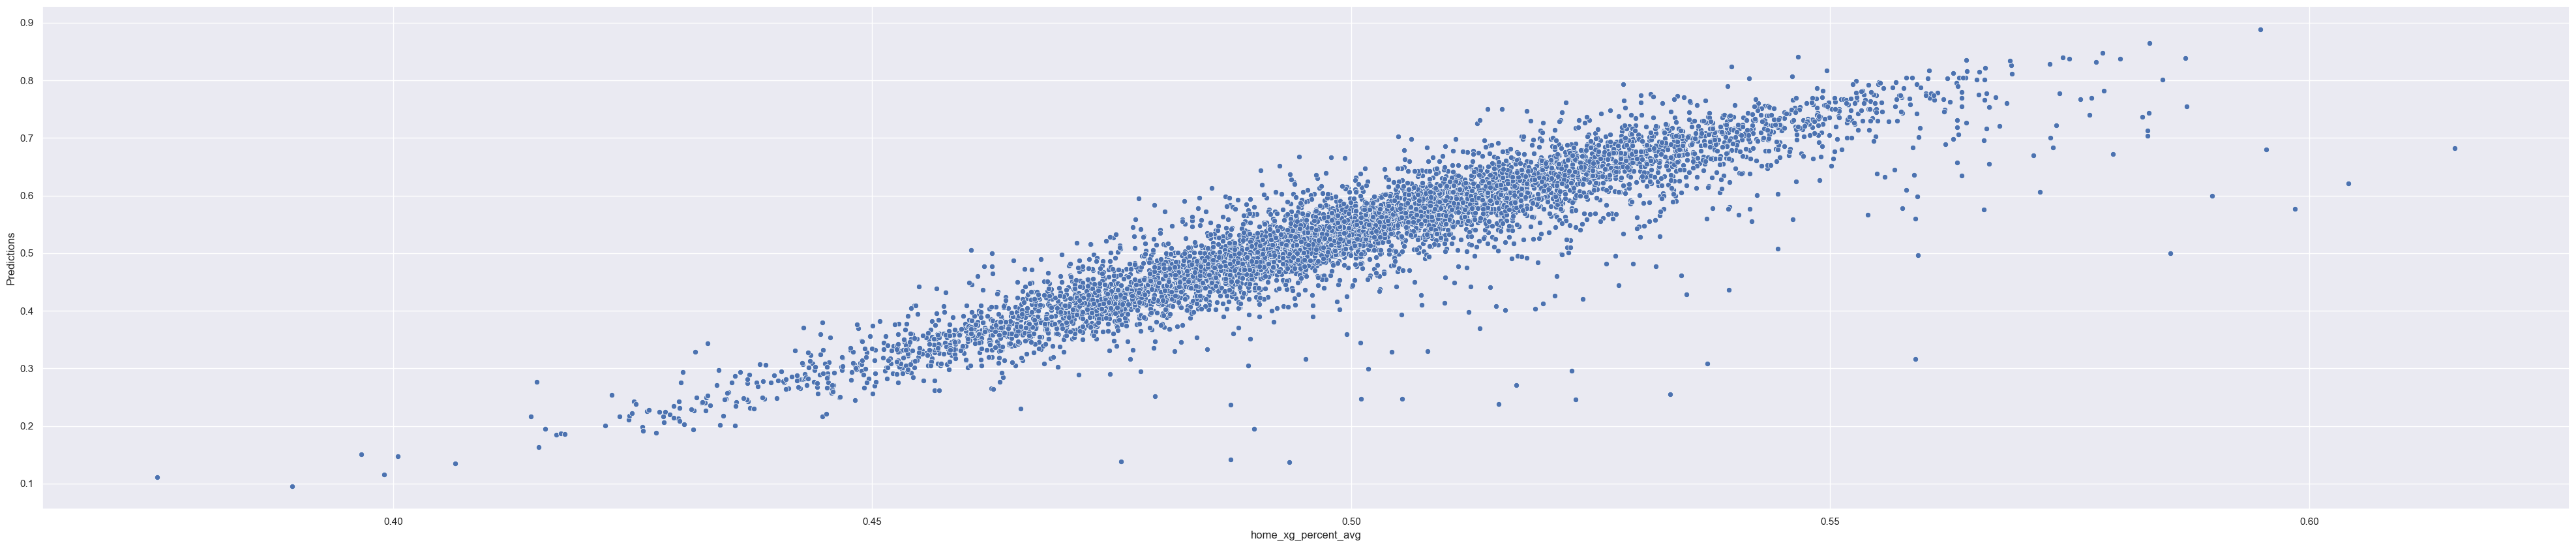

In [51]:



sns.set_theme(rc={'figure.figsize':(50,10)})
sns.scatterplot(x=overall_df["home_xg_percent_avg"], y=overall_df["Predictions"])
# box_plot = sns.boxplot(x=overall_df["home_num_games"], y=overall_df["Predictions"])

# medians = overall_df.groupby(['home_num_games'])['Predictions'].median()
# vertical_offset = overall_df['Predictions'].median() * 0.05
# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
#             horizontalalignment='center',size='large',color='w',weight='semibold')



# sns.scatterplot(x=original_input["Type"], y=original_input["Goal_Probability"])